In [197]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import approx_count_distinct
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


## Criando Sessao e Lendo CSV

In [198]:
spark = SparkSession.builder \
    .appName("Session Atividade 2") \
    .getOrCreate()

customer = spark.read.csv("/user/customer.csv", inferSchema=True, header=True, sep=";")

## Previa do CSV

In [199]:
customer.show()

+-----------+--------+---------+-----+---------+---+--------------------+-------------+---+------------+------+---------------+-------------+---------------+----------------+--------------+--------------+----------+---------------+----------------------+-----------------------+----------------------+---------------+-----------+-----------+--------------+------------------+-------------+----------------+--------+---------+
|CUSTOMER_ID|    LAST|    FIRST|STATE|   REGION|SEX|          PROFESSION|BUY_INSURANCE|AGE|HAS_CHILDREN|SALARY|N_OF_DEPENDENTS|CAR_OWNERSHIP|HOUSE_OWNERSHIP|TIME_AS_CUSTOMER|MARITAL_STATUS|CREDIT_BALANCE|BANK_FUNDS|CHECKING_AMOUNT|MONEY_MONTLY_OVERDRAWN|T_AMOUNT_AUTOM_PAYMENTS|MONTHLY_CHECKS_WRITTEN|MORTGAGE_AMOUNT|N_TRANS_ATM|N_MORTGAGES|N_TRANS_TELLER|CREDIT_CARD_LIMITS|N_TRANS_KIOSK|N_TRANS_WEB_BANK|     LTV|  LTV_BIN|
+-----------+--------+---------+-----+---------+---+--------------------+-------------+---+------------+------+---------------+-------------+-------

## Target = BUY_INSURANCE, aplicar Arvore de decisão

## Verificando tipos

In [200]:
customer.printSchema()

root
 |-- CUSTOMER_ID: string (nullable = true)
 |-- LAST: string (nullable = true)
 |-- FIRST: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- SEX: string (nullable = true)
 |-- PROFESSION: string (nullable = true)
 |-- BUY_INSURANCE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- HAS_CHILDREN: integer (nullable = true)
 |-- SALARY: integer (nullable = true)
 |-- N_OF_DEPENDENTS: integer (nullable = true)
 |-- CAR_OWNERSHIP: integer (nullable = true)
 |-- HOUSE_OWNERSHIP: integer (nullable = true)
 |-- TIME_AS_CUSTOMER: integer (nullable = true)
 |-- MARITAL_STATUS: string (nullable = true)
 |-- CREDIT_BALANCE: integer (nullable = true)
 |-- BANK_FUNDS: integer (nullable = true)
 |-- CHECKING_AMOUNT: integer (nullable = true)
 |-- MONEY_MONTLY_OVERDRAWN: string (nullable = true)
 |-- T_AMOUNT_AUTOM_PAYMENTS: integer (nullable = true)
 |-- MONTHLY_CHECKS_WRITTEN: integer (nullable = true)
 |-- MORTGAGE_AMOUNT: 

## Foram encontrados dados numericos como String, fazendo a correcao:

In [201]:
customer = customer.withColumn("MONEY_MONTLY_OVERDRAWN", regexp_replace(col("MONEY_MONTLY_OVERDRAWN"), ",", ".").cast("float"))
customer = customer.withColumn("LTV", regexp_replace(col("LTV"), ",", ".").cast("float"))

In [202]:
customer.show()

+-----------+--------+---------+-----+---------+---+--------------------+-------------+---+------------+------+---------------+-------------+---------------+----------------+--------------+--------------+----------+---------------+----------------------+-----------------------+----------------------+---------------+-----------+-----------+--------------+------------------+-------------+----------------+--------+---------+
|CUSTOMER_ID|    LAST|    FIRST|STATE|   REGION|SEX|          PROFESSION|BUY_INSURANCE|AGE|HAS_CHILDREN|SALARY|N_OF_DEPENDENTS|CAR_OWNERSHIP|HOUSE_OWNERSHIP|TIME_AS_CUSTOMER|MARITAL_STATUS|CREDIT_BALANCE|BANK_FUNDS|CHECKING_AMOUNT|MONEY_MONTLY_OVERDRAWN|T_AMOUNT_AUTOM_PAYMENTS|MONTHLY_CHECKS_WRITTEN|MORTGAGE_AMOUNT|N_TRANS_ATM|N_MORTGAGES|N_TRANS_TELLER|CREDIT_CARD_LIMITS|N_TRANS_KIOSK|N_TRANS_WEB_BANK|     LTV|  LTV_BIN|
+-----------+--------+---------+-----+---------+---+--------------------+-------------+---+------------+------+---------------+-------------+-------

## Fazendo um Describe dos dados

In [203]:
customer.describe().show()

+-------+-----------+-----+-------+-----+-------+----+---------------+-------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------+------------------+-----------------+------------------+----------------------+-----------------------+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|summary|CUSTOMER_ID| LAST|  FIRST|STATE| REGION| SEX|     PROFESSION|BUY_INSURANCE|               AGE|      HAS_CHILDREN|           SALARY|  N_OF_DEPENDENTS|     CAR_OWNERSHIP|   HOUSE_OWNERSHIP|  TIME_AS_CUSTOMER|MARITAL_STATUS|    CREDIT_BALANCE|       BANK_FUNDS|   CHECKING_AMOUNT|MONEY_MONTLY_OVERDRAWN|T_AMOUNT_AUTOM_PAYMENTS|MONTHLY_CHECKS_WRITTEN|   MORTGAGE_AMOUNT|       N_TRANS_ATM|       N_MORTGAGES|    N_TRANS_TELLER|CREDIT_CARD_LIMITS|     N_TRANS_KIOSK|  N_TRANS_WE

In [204]:
unique_value_counts = {}
for col in customer.columns:
    count = customer.select(approx_count_distinct(col)).collect()[0][0]
    unique_value_counts[col] = count
for col, count in unique_value_counts.items():
    print(f"Column '{col}' has {count} unique values.")

Column 'CUSTOMER_ID' has 1065 unique values.
Column 'LAST' has 852 unique values.
Column 'FIRST' has 857 unique values.
Column 'STATE' has 22 unique values.
Column 'REGION' has 5 unique values.
Column 'SEX' has 2 unique values.
Column 'PROFESSION' has 97 unique values.
Column 'BUY_INSURANCE' has 2 unique values.
Column 'AGE' has 65 unique values.
Column 'HAS_CHILDREN' has 2 unique values.
Column 'SALARY' has 1026 unique values.
Column 'N_OF_DEPENDENTS' has 7 unique values.
Column 'CAR_OWNERSHIP' has 2 unique values.
Column 'HOUSE_OWNERSHIP' has 3 unique values.
Column 'TIME_AS_CUSTOMER' has 5 unique values.
Column 'MARITAL_STATUS' has 5 unique values.
Column 'CREDIT_BALANCE' has 95 unique values.
Column 'BANK_FUNDS' has 272 unique values.
Column 'CHECKING_AMOUNT' has 347 unique values.
Column 'MONEY_MONTLY_OVERDRAWN' has 279 unique values.
Column 'T_AMOUNT_AUTOM_PAYMENTS' has 679 unique values.
Column 'MONTHLY_CHECKS_WRITTEN' has 19 unique values.
Column 'MORTGAGE_AMOUNT' has 244 uniqu

## Removendo dados nao relevantes

In [205]:
columns_to_drop = ["CUSTOMER_ID", "LAST", "FIRST", "PROFESSION", "STATE"]  # Add columns you want to drop here
customer = customer.drop(*columns_to_drop)

## Verificando dados nulos

In [206]:
from pyspark.sql.functions import col

null_counts = [(col_name, customer.where(col(col_name).isNull()).count()) for col_name in customer.columns]
for col_name, count in null_counts:
    print(f"{col_name}: {count}")


REGION: 0
SEX: 0
BUY_INSURANCE: 0
AGE: 0
HAS_CHILDREN: 0
SALARY: 0
N_OF_DEPENDENTS: 0
CAR_OWNERSHIP: 0
HOUSE_OWNERSHIP: 0
TIME_AS_CUSTOMER: 0
MARITAL_STATUS: 0
CREDIT_BALANCE: 0
BANK_FUNDS: 0
CHECKING_AMOUNT: 0
MONEY_MONTLY_OVERDRAWN: 0
T_AMOUNT_AUTOM_PAYMENTS: 0
MONTHLY_CHECKS_WRITTEN: 0
MORTGAGE_AMOUNT: 0
N_TRANS_ATM: 0
N_MORTGAGES: 0
N_TRANS_TELLER: 0
CREDIT_CARD_LIMITS: 0
N_TRANS_KIOSK: 0
N_TRANS_WEB_BANK: 0
LTV: 0
LTV_BIN: 0


## Sem dados Nulos!

In [207]:
var_categoricas = ['REGION', 'SEX', 'MARITAL_STATUS', 'LTV_BIN']
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(customer)
    for column in var_categoricas
]
pipeline = Pipeline(stages=indexers)
customer = pipeline.fit(customer).transform(customer)
customer = customer.drop(*var_categoricas)

feature_cols = customer.columns.copy()
feature_cols.remove("BUY_INSURANCE")

vector_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

customer = vector_assembler.transform(customer)

customer = customer.select(
    col("features").alias("features"),
    col("BUY_INSURANCE").alias("label"))


customer = customer.withColumn("label", when(customer["label"] == "No", 0).otherwise(1))
customer.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[49.0,1.0,68696.0...|    0|
|(25,[0,2,4,6,9,10...|    0|
|[26.0,1.0,60249.0...|    0|
|[32.0,0.0,60466.0...|    0|
|(25,[0,2,3,4,5,6,...|    0|
|[35.0,1.0,62756.0...|    0|
|[36.0,1.0,62886.0...|    0|
|[26.0,1.0,61012.0...|    0|
|(25,[0,1,2,4,6,9,...|    0|
|[49.0,1.0,60322.0...|    0|
|(25,[0,1,2,4,6,9,...|    0|
|[52.0,1.0,73090.0...|    0|
|[31.0,0.0,71782.0...|    0|
|[44.0,1.0,61056.0...|    0|
|[52.0,0.0,59480.0...|    0|
|(25,[0,2,4,6,9,10...|    0|
|[69.0,1.0,61943.0...|    0|
|[46.0,1.0,64648.0...|    0|
|[42.0,1.0,58327.0...|    0|
|[28.0,0.0,60968.0...|    0|
+--------------------+-----+
only showing top 20 rows



In [208]:
(train_data, test_data) = customer.randomSplit([0.7, 0.3], seed=420)

dt = DecisionTreeClassifier(featuresCol="features")
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 40, 60, 80]) \
    .build()


crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
predictions = bestModel.transform(test_data)
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.8796711509715994


In [209]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.8498402555910544
Precision: 0.8621285880890186
Recall: 0.8498402555910544
F1 Score: 0.8533440362635478


In [234]:


regras = bestModel.toDebugString.replace("Predict: 1.0", "BUY_INSURANCE: Yes").replace("Predict: 0.0", "BUY_INSURANCE: No")
f = 0
used_features = []
for feature in feature_cols:
    regras = regras.replace(f"feature {f} ", f"{feature} ")
    if feature in regras:
        used_features.append(feature)
    f = f +1
print(regras)
print(used_features)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f3dfdd5cb9d4, depth=5, numNodes=25, numClasses=2, numFeatures=25
  If (BANK_FUNDS <= 225.5)
   If (CREDIT_CARD_LIMITS <= 650.0)
    If (AGE <= 32.5)
     If (N_OF_DEPENDENTS <= 0.5)
      BUY_INSURANCE: Yes
     Else (N_OF_DEPENDENTS > 0.5)
      BUY_INSURANCE: No
    Else (AGE > 32.5)
     BUY_INSURANCE: No
   Else (CREDIT_CARD_LIMITS > 650.0)
    BUY_INSURANCE: No
  Else (BANK_FUNDS > 225.5)
   If (CHECKING_AMOUNT <= 128.0)
    If (CREDIT_BALANCE <= 350.0)
     If (MONEY_MONTLY_OVERDRAWN <= 53.83500099182129)
      If (T_AMOUNT_AUTOM_PAYMENTS <= 1298.0)
       BUY_INSURANCE: Yes
      Else (T_AMOUNT_AUTOM_PAYMENTS > 1298.0)
       BUY_INSURANCE: No
     Else (MONEY_MONTLY_OVERDRAWN > 53.83500099182129)
      BUY_INSURANCE: Yes
    Else (CREDIT_BALANCE > 350.0)
     If (MONTHLY_CHECKS_WRITTEN <= 16.5)
      BUY_INSURANCE: No
     Else (MONTHLY_CHECKS_WRITTEN > 16.5)
      BUY_INSURANCE: Yes
   Else (CHECKING_AMOUNT > 128.0)
 

In [236]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:


        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    return json

import json
dict_tree_json = debug_str_to_json(regras)
print(json.dumps(dict_tree_json,indent = 1 ))

{
 "name": "Root",
 "children": [
  {
   "name": "BANK_FUNDS <= 225.5",
   "children": [
    {
     "name": "CREDIT_CARD_LIMITS <= 650.0",
     "children": [
      {
       "name": "AGE <= 32.5",
       "children": [
        {
         "name": "N_OF_DEPENDENTS <= 0.5",
         "children": [
          {
           "name": "BUY_INSURANCE: Yes"
          }
         ]
        },
        {
         "name": "N_OF_DEPENDENTS > 0.5",
         "children": [
          {
           "name": "BUY_INSURANCE: No"
          }
         ]
        }
       ]
      },
      {
       "name": "AGE > 32.5",
       "children": [
        {
         "name": "BUY_INSURANCE: No"
        }
       ]
      }
     ]
    },
    {
     "name": "CREDIT_CARD_LIMITS > 650.0",
     "children": [
      {
       "name": "BUY_INSURANCE: No"
      }
     ]
    }
   ]
  },
  {
   "name": "BANK_FUNDS > 225.5",
   "children": [
    {
     "name": "CHECKING_AMOUNT <= 128.0",
     "children": [
      {
       "name": "CREDIT_BALAN

https://vanya.jp.net/vtree/

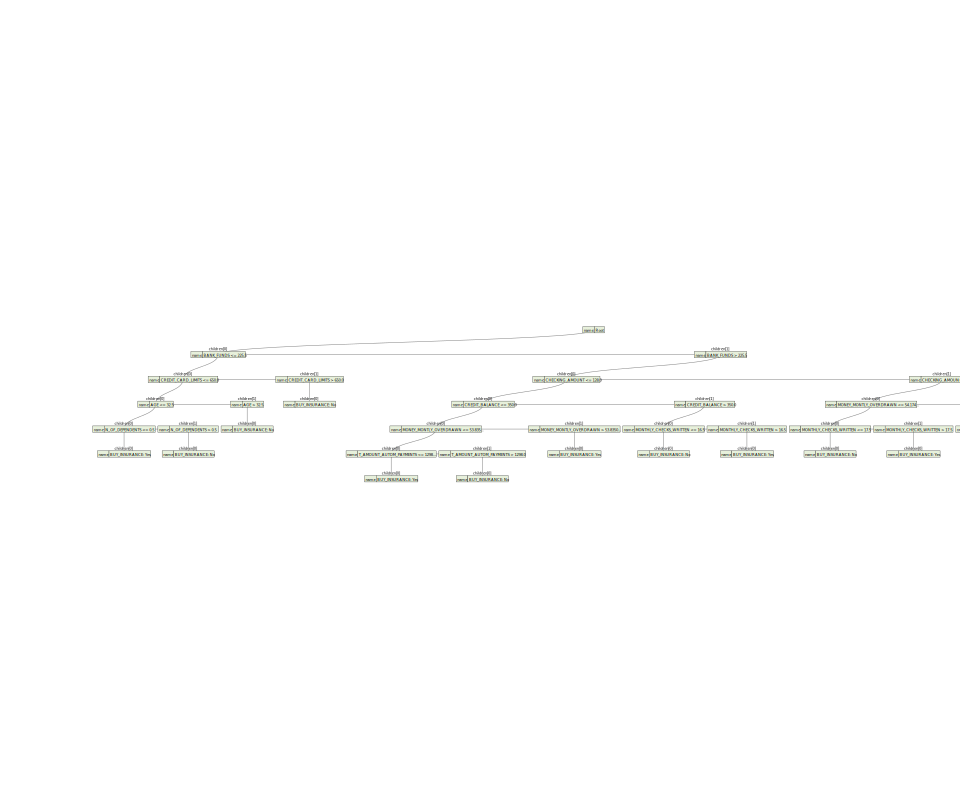

In [262]:
from IPython.display import SVG, display
def show_svg():
    display(SVG(filename='/home/glauco/staging/dt.svg'))
show_svg()


In [ ]:
# #################################################
# #Plotando a curva ROC
# #################################################

# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType
# import matplotlib.pyplot as plt

# # Define a UDF to extract the probability of the positive class
# def extract_probability(probability_vector):
#     return float(probability_vector[1])

# extract_prob_udf = udf(extract_probability, FloatType())

# # Update the DataFrame to include a column for the positive class probability
# predictions = predictions.withColumn("positive_probability", extract_prob_udf("probability"))

# # Now compute the ROC curve
# thresholds = [i / 100.0 for i in range(100)]  # Creating a list of threshold values from 0 to 1
# roc_points = []

# for threshold in thresholds:
#     # Create a new column 'predicted_label' based on the probability threshold
#     prediction_with_threshold = predictions.withColumn('predicted_label', (col("positive_probability") >= threshold).cast("integer"))

#     # True Positive (TP): correctly predicted positive observations
#     TP = prediction_with_threshold.filter('predicted_label = 1 AND label = 1').count()
#     # False Positive (FP): incorrectly predicted positive observations
#     FP = prediction_with_threshold.filter('predicted_label = 1 AND label = 0').count()
#     # True Negative (TN): correctly predicted negative observations
#     TN = prediction_with_threshold.filter('predicted_label = 0 AND label = 0').count()
#     # False Negative (FN): incorrectly predicted negative observations
#     FN = prediction_with_threshold.filter('predicted_label = 0 AND label = 1').count()
    
#     # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
#     TPR = TP / (TP + FN) if (TP + FN) else 0
#     FPR = FP / (FP + TN) if (FP + TN) else 0
    
#     roc_points.append((FPR, TPR))

# # Extract FPR and TPR into separate lists for plotting
# fpr, tpr = zip(*roc_points)

# # Plot ROC curve using Matplotlib
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from py4j.java_gateway import java_import
import pydot

# Convert Spark DataFrame to Pandas DataFrame for visualization
train_data_pd = train_data.toPandas()


# Define feature columns
feature_columns = train_data.columns
feature_columns.remove("label")

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data_assembled = assembler.transform(train_data_pd)

# Train decision tree model
dt = DecisionTreeClassifier(labelCol="target", featuresCol="features")
dt_model = dt.fit(train_data_assembled)

# Convert Spark DecisionTreeClassificationModel to Py4j DecisionTreeModel
java_import(spark._jvm, "org.apache.spark.mllib")
java_import(spark._jvm, "org.apache.spark.mllib.tree.model")
java_import(spark._jvm, "org.apache.spark.mllib.util.MLWritable")
java_import(spark._jvm, "org.apache.spark.mllib.util.MLReader")
java_import(spark._jvm, "org.apache.spark.mllib.tree.DecisionTreeModel")
java_import(spark._jvm, "org.apache.spark.ml.util.MLWritable")
java_import(spark._jvm, "org.apache.spark.ml.util.MLReader")

dt_java_model = spark._jvm.org.apache.spark.ml.util.MLWritable.write().overwrite().save(
    dt_model._java_obj, "temp_model"
)
dt_mllib_model = spark._jvm.org.apache.spark.mllib.tree.model.DecisionTreeModel.load(
    spark._jsc.sc(), "temp_model"
)

# Visualize decision tree
dot_data = dt_mllib_model.toDebugString()
graph = pydot.graph_from_dot_data(dot_data)
graph[0].write_png("decision_tree.png")


AttributeError: 'DataFrame' object has no attribute '_jdf'